In [4]:
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [49]:
import pandas as pd
data=pd.read_csv('data.txt',delim_whitespace=True,header=None)
data.columns=['index','year','month','day','day of year','anomaly']
data.head()

,index,year,month,day,day of year,anomaly
0,1880.001,1880,1,1,1,-0.786
1,1880.004,1880,1,2,2,-0.695
2,1880.007,1880,1,3,3,-0.783
3,1880.010,1880,1,4,4,-0.725
4,1880.012,1880,1,5,5,-0.802


In [50]:
data['avg_temp']=data['anomaly'].values+8
data.head()

,index,year,month,day,day of year,anomaly,avg_temp
0,1880.001,1880,1,1,1,-0.786,7.214
1,1880.004,1880,1,2,2,-0.695,7.305
2,1880.007,1880,1,3,3,-0.783,7.217
3,1880.010,1880,1,4,4,-0.725,7.275
4,1880.012,1880,1,5,5,-0.802,7.198


In [51]:
dataframe=data['avg_temp']
dataset = dataframe.values
dataset = dataset.astype('float32')
dataframe.head()

0    7.214
1    7.305
2    7.217
3    7.275
4    7.198
Name: avg_temp, dtype: float64

In [52]:
dataset

array([7.214, 7.305, 7.217, ..., 8.611, 8.636, 8.976], dtype=float32)

In [53]:
dataset.reshape(-1,1)
dataset

array([7.214, 7.305, 7.217, ..., 8.611, 8.636, 8.976], dtype=float32)

In [ ]:
# load the dataset
dataframe = pandas.read_csv('NSE-BSE.csv', usecols=[5], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
dataframe.head()

In [ ]:
dataset

In [54]:
#Change array from 1D to 2D and take transpose
a= dataset.reshape(1,-1) #Step1
a=a.T
a.shape

(50769, 1)

In [55]:
dataset=a
dataset.shape

(50769, 1)

In [56]:
dataset

array([[7.214],
       [7.305],
       [7.217],
       ...,
       [8.611],
       [8.636],
       [8.976]], dtype=float32)

In [57]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.3376487 ],
       [0.35356885],
       [0.33817357],
       ...,
       [0.5820504 ],
       [0.58642405],
       [0.64590615]], dtype=float32)

In [58]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

34015 16754


In [ ]:
test

In [59]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=5):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
dataX

In [60]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [67]:
testX

array([[[0.62508756]],

       [[0.61966413]],

       [[0.606893  ]],

       ...,

       [[0.6439819 ]],

       [[0.6089924 ]],

       [[0.5820504 ]]], dtype=float32)

In [61]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX

In [62]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=100, verbose=2)

Epoch 1/10
 - 2s - loss: 0.0322
Epoch 2/10
 - 1s - loss: 0.0033
Epoch 3/10
 - 1s - loss: 0.0027
Epoch 4/10
 - 1s - loss: 0.0021
Epoch 5/10
 - 1s - loss: 0.0015
Epoch 6/10
 - 1s - loss: 0.0010
Epoch 7/10
 - 1s - loss: 7.5393e-04
Epoch 8/10
 - 1s - loss: 6.5773e-04
Epoch 9/10
 - 1s - loss: 6.3380e-04
Epoch 10/10
 - 1s - loss: 6.2990e-04


In [63]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.14 RMSE
Test Score: 0.16 RMSE


In [64]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions


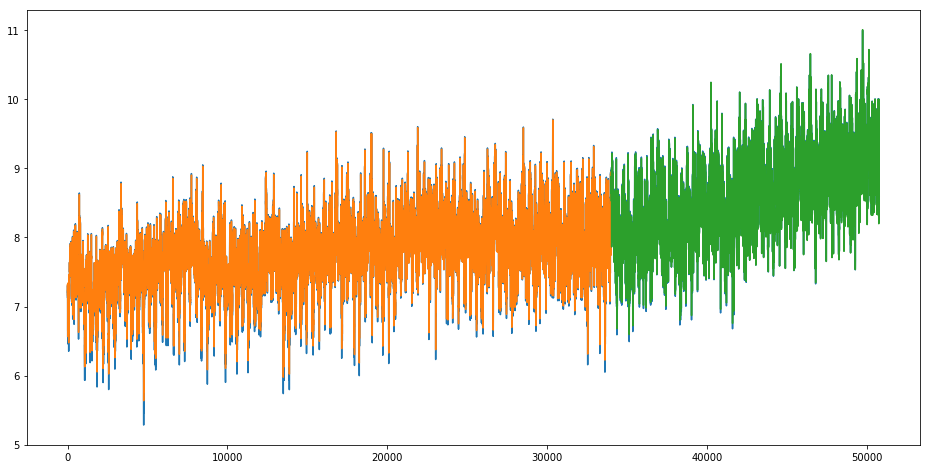

In [65]:
plt.figure(figsize=(16,8))

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [71]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [testX[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = scaler.inverse_transform(preds_moving)
    
    return preds_moving

In [73]:
import numpy as np
preds_moving = moving_test_window_preds(500)


ValueError: Expected 2D array, got 1D array instead:
array=[0.62118959 0.61726886 0.61332756 0.60936803 0.60539275 0.60140413
 0.5974046  0.59339708 0.5893842  0.58536875 0.58135349 0.57734168
 0.57333612 0.56933999 0.56535643 0.56138843 0.55743921 0.55351192
 0.54960966 0.5457356  0.54189283 0.53808445 0.53431338 0.53058261
 0.52689499 0.5232532  0.51965988 0.51611763 0.51262891 0.50919592
 0.50582093 0.50250572 0.49925238 0.49606252 0.49293765 0.48987919
 0.48688835 0.48396608 0.48111328 0.47833067 0.47561881 0.472978
 0.47040853 0.46791041 0.46548358 0.46312785 0.46084267 0.45862779
 0.45648253 0.45440608 0.45239767 0.45045635 0.44858113 0.44677085
 0.44502437 0.44334045 0.4417178  0.44015503 0.43865073 0.4372035
 0.435812   0.43447459 0.43318987 0.43195632 0.43077239 0.42963669
 0.4285475  0.4275035  0.42650309 0.42554486 0.42462739 0.42374918
 0.42290881 0.42210492 0.4213362  0.42060128 0.41989887 0.41922778
 0.4185867  0.41797444 0.41738987 0.41683182 0.41629925 0.41579109
 0.4153063  0.41484386 0.41440284 0.41398239 0.41358149 0.41319939
 0.41283524 0.41248819 0.41215757 0.41184253 0.41154248 0.4112567
 0.41098455 0.41072533 0.41047856 0.41024363 0.41001996 0.40980709
 0.40960452 0.4094117  0.40922821 0.40905359 0.40888742 0.40872931
 0.40857893 0.40843585 0.40829977 0.40817025 0.40804711 0.40793002
 0.40781859 0.40771261 0.40761185 0.40751594 0.40742484 0.4073382
 0.40725583 0.40717745 0.40710294 0.40703207 0.40696475 0.40690073
 0.40683988 0.406782   0.40672702 0.40667474 0.40662503 0.40657774
 0.40653282 0.40649012 0.4064495  0.40641087 0.40637425 0.40633941
 0.40630624 0.40627474 0.40624481 0.40621632 0.40618926 0.40616354
 0.40613914 0.40611592 0.40609381 0.40607285 0.40605292 0.40603399
 0.40601599 0.40599886 0.40598258 0.40596712 0.40595242 0.40593842
 0.40592512 0.40591255 0.40590057 0.40588915 0.40587837 0.40586808
 0.40585828 0.40584898 0.40584016 0.40583175 0.4058238  0.40581617
 0.40580896 0.40580216 0.40579569 0.40578952 0.40578368 0.40577808
 0.40577278 0.40576774 0.40576291 0.40575838 0.40575406 0.40574995
 0.40574607 0.40574238 0.40573886 0.40573555 0.40573236 0.40572932
 0.40572649 0.40572381 0.40572119 0.40571871 0.40571636 0.40571409
 0.40571198 0.40570992 0.40570801 0.4057062  0.40570447 0.40570283
 0.40570125 0.40569976 0.40569836 0.40569699 0.40569574 0.40569454
 0.40569341 0.40569228 0.40569127 0.40569028 0.40568936 0.40568849
 0.40568763 0.40568686 0.40568608 0.40568537 0.40568465 0.40568402
 0.40568343 0.40568283 0.40568227 0.40568176 0.40568128 0.40568081
 0.40568033 0.40567991 0.40567943 0.40567908 0.40567872 0.40567833
 0.405678   0.40567765 0.40567732 0.40567708 0.40567681 0.40567657
 0.40567631 0.40567607 0.40567586 0.40567565 0.40567544 0.40567523
 0.40567505 0.4056749  0.4056747  0.40567455 0.40567437 0.40567419
 0.40567407 0.40567392 0.40567386 0.40567377 0.40567365 0.40567356
 0.40567344 0.40567335 0.40567324 0.40567318 0.40567306 0.405673
 0.40567294 0.40567291 0.40567288 0.40567282 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279 0.40567279
 0.40567279 0.40567279].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.